In [3]:
import tensorflow as tf

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import warnings
warnings.filterwarnings("ignore")

# Helper function to check for corrupt images
def check_images(directory):
    bad_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            try:
                img = Image.open(os.path.join(root, file))
                img.verify()
            except (IOError, SyntaxError) as e:
                bad_images.append(os.path.join(root, file))
    return bad_images

train_dir = "D:\\pest\\plants\\train"
test_dir = "D:\\pest\\plants\\test"

bad_train_images = check_images(train_dir)
bad_test_images = check_images(test_dir)

print(f"Corrupt images in train directory: {bad_train_images}")
print(f"Corrupt images in test directory: {bad_test_images}")

# Optionally, remove corrupt images
for img in bad_train_images + bad_test_images:
    os.remove(img)

model_d = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3)) 

x = model_d.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x) 
x = Dense(512, activation='relu')(x) 
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

preds = Dense(2, activation='softmax')(x)  # FC-layer

model = Model(inputs=model_d.input, outputs=preds)
# model.summary()

for layer in model.layers[:-8]:
    layer.trainable = False
    
for layer in model.layers[-8:]:
    layer.trainable = True

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

trdata = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
tsdata = ImageDataGenerator(rescale=1./255)

traindata = trdata.flow_from_directory(
    directory=train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'  # Change to 'categorical'
)
testdata = tsdata.flow_from_directory(
    directory=test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'  # Change to 'categorical'
)

checkpoint = ModelCheckpoint("DenseNet121.keras", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='max')

history = model.fit(traindata, validation_data=testdata, epochs=20, callbacks=[checkpoint, early])


Corrupt images in train directory: []
Corrupt images in test directory: []
Found 13629 images belonging to 2 classes.
Found 1027 images belonging to 2 classes.
Epoch 1/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9363 - loss: 0.2006
Epoch 1: val_accuracy improved from -inf to 0.98345, saving model to DenseNet121.keras
426/426 ━━━━━━━━━━━━━━━━━━━━ 1164s 3s/step - accuracy: 0.9364 - loss: 0.2004 - val_accuracy: 0.9834 - val_loss: 0.0376
Epoch 2/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9725 - loss: 0.0741
Epoch 2: val_accuracy improved from 0.98345 to 0.98734, saving model to DenseNet121.keras
426/426 ━━━━━━━━━━━━━━━━━━━━ 958s 2s/step - accuracy: 0.9725 - loss: 0.0741 - val_accuracy: 0.9873 - val_loss: 0.0270
Epoch 3/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9782 - loss: 0.0547
Epoch 3: val_accuracy did not improve from 0.98734
426/426 ━━━━━━━━━━━━━━━━━━━━ 854s 2s/step - accuracy: 0.9782 - loss: 0.0547 - val_accuracy: 0.9854 - val_loss: 0.0362
Ep

In [4]:
accuracy = model.evaluate(testdata)

print('Test set accuracy:', accuracy[1]*100)

33/33 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.9993 - loss: 0.0034
Test set accuracy: 99.80525970458984


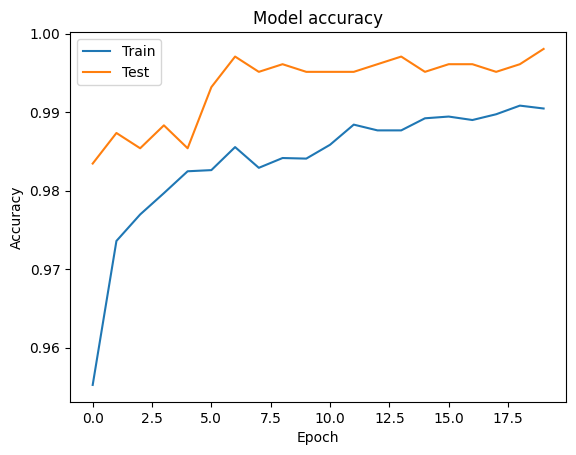

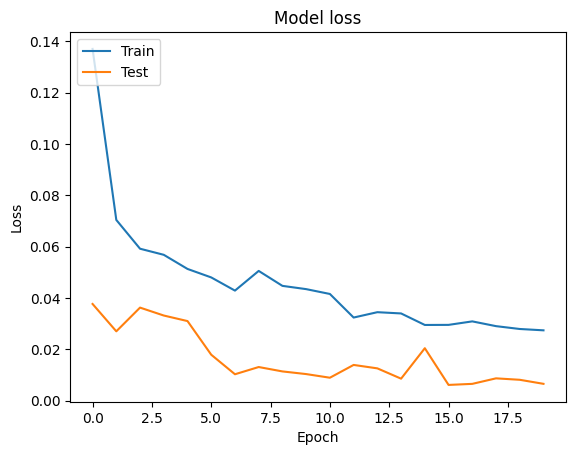

In [5]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [6]:
model.save("pest_model.h5", include_optimizer=True)